In [1]:
%load_ext autoreload
%autoreload 2

import cPickle as pickle
import os; import sys; sys.path.append('..'); sys.path.append('../gp/')
import gp
import gp.nets as nets

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support, f1_score, precision_recall_curve, average_precision_score, zero_one_loss


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
NETS = []
NETS.append('../nets/IPMLB_FULL.p') # image + prob + binary + large border

network_path = NETS[-1]

with open(network_path, 'rb') as f:
    net = pickle.load(f)

In [3]:
# load cremi A data
import h5py
import mahotas as mh
import numpy as np
import tifffile as tif

In [4]:
input_image = np.zeros((2,1250,1250))
input_rhoana = np.zeros((2,1250,1250), dtype=np.uint64)
input_gold = np.zeros((2,1250,1250), dtype=np.uint64)
input_prob = np.zeros((2,1250,1250))

for z in range(2):
    image, prob, gold, rhoana = gp.Cremi.read_section('/home/d/data/CREMI/C/', z)
    input_image[z] = image
    input_prob[z] = prob
    input_gold[z] = gold
    input_rhoana[z] = rhoana

Loading 000000000_000000000_000000000_image.png
Loading 000000000_000000000_000000001_image.png


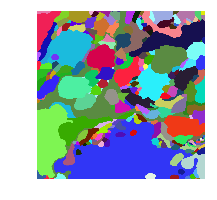

In [5]:
gp.Util.view(gold)

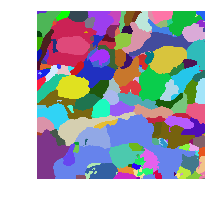

In [6]:
gp.Util.view(rhoana)

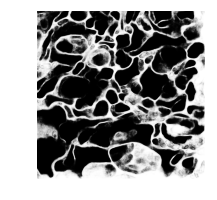

In [7]:
gp.Util.view(prob, color=False)

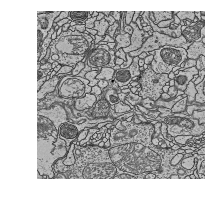

In [8]:
gp.Util.view(image, color=False)

In [9]:
gp.Util.vi(input_rhoana, input_gold)

2.032825794062817

In [10]:
gp.metrics.adapted_rand(input_rhoana, input_gold)

0.58514442753365858

In [11]:
net.uuid = 'IPMLB'
bigM_cremiB = gp.Legacy.create_bigM_without_mask(net, input_image, input_prob, input_rhoana, verbose=True)

1648 generated in 32.1830060482 seconds.
Grouped into 296 patches in 0.00803518295288 seconds.
1760 generated in 37.3747820854 seconds.
Grouped into 305 patches in 0.0077919960022 seconds.


In [12]:
bigM_cA_after_95, out_cA_volume_after_auto_95, cA_auto_fixes_95, cA_auto_vi_s_95 = gp.Legacy.splits_global_from_M_automatic(net, 
                                                                                                                            bigM_cremiB, 
                                                                                                                            input_image, 
                                                                                                                            input_prob, 
                                                                                                                            input_rhoana,
                                                                                                                            input_gold, 
                                                                                                                            sureness_threshold=.95)


In [13]:
gp.Util.vi(out_cA_volume_after_auto_95, input_gold)

2.9363190425761205

In [14]:
gp.metrics.adapted_rand(out_cA_volume_after_auto_95, input_gold)

0.77019023534857156

In [15]:
cA_auto_fixes_95

[(0, 0.99999666213989258),
 (0, 0.99998331069946289),
 (0, 0.99997556209564209),
 (0, 0.99996280670166016),
 (1, 0.9999578595161438),
 (0, 0.99995410442352295),
 (1, 0.99993646144866943),
 (0, 0.999930739402771),
 (1, 0.99991261959075928),
 (1, 0.99991154670715332),
 (1, 0.99995994567871094),
 (0, 0.99990248680114746),
 (0, 0.99984288215637207),
 (1, 0.99984192848205566),
 (0, 0.99983119964599609),
 (0, 0.99978169798851013),
 (0, 0.99977171421051025),
 (0, 0.99974232912063599),
 (0, 0.99972695112228394),
 (0, 0.99972623586654663),
 (1, 0.99968212842941284),
 (0, 0.99967628717422485),
 (0, 0.99961256980895996),
 (0, 0.99960362911224365),
 (0, 0.99972695112228394),
 (1, 0.99953120946884155),
 (1, 0.99950551986694336),
 (1, 0.99963210060069563),
 (0, 0.9993402361869812),
 (0, 0.99932390451431274),
 (1, 0.99922299385070801),
 (0, 0.99921345710754395),
 (1, 0.99920111894607544),
 (0, 0.99915897846221924),
 (0, 0.99927312135696411),
 (1, 0.99912625551223755),
 (1, 0.99892324209213257),
 (0, 